In [1]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import jax.numpy as jnp
from jax.scipy import optimize
import jax
jax.config.update("jax_enable_x64", True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit

from lib.simdata_i3 import I3SimHandlerFtr
from lib.plotting import plot_event, adjust_plot_1d
from lib.geo import center_track_pos_and_time_based_on_data

from lib.network import get_network_eval_v_fn

from dom_track_eval import get_eval_network_doms_and_track
from likelihood_spe import get_neg_c_triple_gamma_llh
from likelihood_spe import get_llh_and_grad_fs_for_iminuit_migrad

from palettable.cubehelix import Cubehelix
cx =Cubehelix.make(start=0.3, rotation=-0.5, n=16, reverse=False, gamma=1.0,
                           max_light=1.0,max_sat=0.5, min_sat=1.4).get_mpl_colormap()

In [2]:
# Get network and eval logic.
eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/jax_reco/data/network')
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v)

# Get likelihoods
neg_llh, neg_llh_grad = get_llh_and_grad_fs_for_iminuit_migrad(eval_network_doms_and_track)

muon energy: 2.0 TeV
n_doms 97


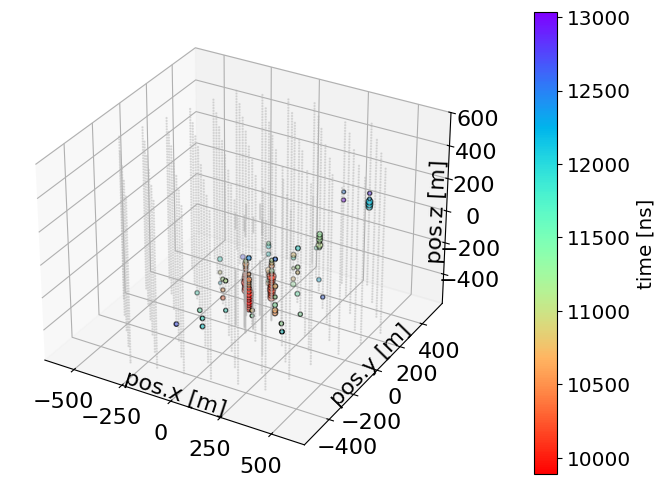

In [3]:
# Event Index.
event_index = 1

# Get an IceCube event.
bp = '/home/storage2/hans/i3files/21217'
sim_handler = I3SimHandlerFtr(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'),
                              os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'),
                              '/home/storage/hans/jax_reco/data/icecube/detector_geometry.csv')

meta, pulses = sim_handler.get_event_data(event_index)
print(f"muon energy: {meta['muon_energy_at_detector']/1.e3:.1f} TeV")

# Get dom locations, first hit times, and total charges (for each dom).
event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

print("n_doms", len(event_data))

# Produce and save an event view.
plot_event(event_data, geo=sim_handler.geo)

In [4]:
track_pos = jnp.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
track_time = meta['muon_time']
track_zenith = meta['muon_zenith']
track_azimuth = meta['muon_azimuth']
track_src = jnp.array([track_zenith, track_azimuth])

print("old track vertex:", track_pos)
centered_track_pos, centered_track_time = center_track_pos_and_time_based_on_data(event_data, track_pos, track_time, track_src)
print("new track vertex:", centered_track_pos)

# Create some n_photons from qtot (by rounding up).
n_photons = np.round(event_data['charge'].to_numpy()+0.5)

# Combine into single data tensor for fitting.
fitting_event_data = jnp.column_stack([
                                        jnp.array(event_data[['x', 'y', 'z', 'time']].to_numpy()),
                                        jnp.array(n_photons)
                                   ])

old track vertex: [ -57.58777311  104.94960582 -459.58699572]
new track vertex: [  79.52905078  241.90677754 -291.78433739]


In [5]:
f_prime = lambda x: neg_llh(x, centered_track_time, fitting_event_data)
grad_prime = lambda x: neg_llh_grad(x, centered_track_time, fitting_event_data)

x0 = jnp.concatenate([track_src, centered_track_pos])
m = Minuit(f_prime, x0, grad=grad_prime)
m.errordef = Minuit.LIKELIHOOD
m.limits = ((0.0, np.pi), (0.0, 2.0 * np.pi), (-500.0, 500.0),  (-500.0, 500.0),  (-500.0, 500.0))
m.strategy = 0
m.migrad()
print(m.fval)

1353.1659420784276


In [6]:
print(np.rad2deg(meta['spline_mpe_zenith']-track_src[0]))
print(np.rad2deg(meta['spline_mpe_azimuth']-track_src[1]))

0.47835798562202686
-6.762578161498366


In [7]:
smpe_track_pos = jnp.array([meta['spline_mpe_pos_x'], meta['spline_mpe_pos_y'], meta['spline_mpe_pos_z']])
smpe_track_time = meta['spline_mpe_time']
smpe_track_zenith = meta['spline_mpe_zenith']
smpe_track_azimuth = meta['spline_mpe_azimuth']
smpe_track_src = jnp.array([track_zenith, track_azimuth])

print("old track vertex:", smpe_track_pos)
smpe_centered_track_pos, smpe_centered_track_time = center_track_pos_and_time_based_on_data(event_data, 
                                                                                            smpe_track_pos, 
                                                                                            smpe_track_time, 
                                                                                            smpe_track_src)
print("new track vertex:", smpe_centered_track_pos)

old track vertex: [ -14.95262743  151.04664187 -404.81947557]
new track vertex: [  77.78463717  243.6759277  -291.32822712]


In [8]:
f_prime = lambda x: neg_llh(x, smpe_centered_track_time, fitting_event_data)
grad_prime = lambda x: neg_llh_grad(x, smpe_centered_track_time, fitting_event_data)

x0 = jnp.concatenate([smpe_track_src, smpe_centered_track_pos])
m = Minuit(f_prime, x0, grad=grad_prime)
m.errordef = Minuit.LIKELIHOOD
m.limits = ((0.0, np.pi), (0.0, 2.0 * np.pi), (-500.0, 500.0),  (-500.0, 500.0),  (-500.0, 500.0))
m.strategy = 0
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1352                       │        Nfcn = 49, Ngrad = 10         │
│ EDM = 5.95e-06 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   2.293   │   0.004   │            │            │    0    │ 3.14159 │       │
│ 1 │ x1   │   3.922   │   0.006   │            │            │    0    │ 6.28319 │       │
│ 2 │ x2   │   79.8    │    0.6    │            │            │  -500   │   500   │       │
│ 3 │ x3   │   241.8   │    0.6    │            │            │  -500   │   500   │       │
│ 4 │ x4   │  -290.6   │    0.5    │            │            │  -500   │   500   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4 │
├────┼───────────────────────────────────────────────────┤
│ x0 │  1.27e-05  0.010e-3  0.643e-3  0.057e-3  0.734e-3 │
│ x1 │  0.010e-3  3.38e-05  2.418e-3 -1.314e-3  2.422e-3 │
│ x2 │  0.643e-3  2.418e-3      0.39     -0.24      0.22 │
│ x3 │  0.057e-3 -1.314e-3     -0.24     0.331     -0.02 │
│ x4 │  0.734e-3  2.422e-3      0.22     -0.02      0.25 │
└────┴───────────────────────────────────────────────────┘

In [8]:
def GreatCircleDistance(azi_1, zen_1, azi_2, zen_2):
        ra_1 = azi_1
        ra_2 = azi_2
        dec_1 = np.pi/2.0 - zen_1
        dec_2 = np.pi/2.0 - zen_2
        '''Compute the great circle distance between two events'''
        '''All coordinates must be given in radians'''
        delta_dec = np.abs(dec_1 - dec_2)
        delta_ra = np.abs(ra_1 - ra_2)
        x = (np.sin(delta_dec / 2.))**2. + np.cos(dec_1) *\
            np.cos(dec_2) * (np.sin(delta_ra / 2.))**2.
        return 2. * np.arcsin(np.sqrt(x))

print(np.rad2deg(GreatCircleDistance(m.values[1], m.values[0], track_src[1], track_src[0])))

0.5343860875252834


In [9]:
for i in range(3):
    print(smpe_centered_track_pos[i]-centered_track_pos[i])

-1.7444136085952806
1.7691501658558195
0.45611026870034266


In [10]:
# todo future: replace naive draw in zenith, azimuth by spherical draw from sphere to avoid issues at poles.
# e.g. use this: https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/VonMisesFisher

n_seeds = 10
seed = 0
key = jax.random.key(seed)

key, subkey = jax.random.split(key)
rvals =  jax.random.normal(subkey, (n_seeds, 5))

seed_zenith = smpe_track_src[0] + np.deg2rad(1) * rvals[:, 0]
seed_zenith = jnp.clip(seed_zenith, 0.0, jnp.pi)

seed_azimuth = smpe_track_src[1] + np.deg2rad(1) * rvals[:, 1]
seed_azimuth = jnp.clip(seed_azimuth, 0.0, 2.0*jnp.pi)

seed_pos = smpe_track_pos + 5.0 * rvals[:, 2:]

random_seeds = jnp.column_stack([seed_zenith, seed_azimuth, seed_pos])
random_seeds = jnp.concatenate([jnp.concatenate([smpe_track_src, smpe_track_pos]).reshape((1,5)), random_seeds], axis=0)

In [11]:
f_prime = lambda x: neg_llh(x, smpe_centered_track_time, fitting_event_data)
grad_prime = lambda x: neg_llh_grad(x, smpe_centered_track_time, fitting_event_data)


In [12]:
def run_seeds(x0):
    logls = []
    directions = []
    for x0 in random_seeds:
        m = Minuit(f_prime, x0, grad=grad_prime)
        m.errordef = Minuit.LIKELIHOOD
        m.limits = ((0.0, np.pi), (0.0, 2.0 * np.pi), (-500.0, 500.0),  (-500.0, 500.0),  (-500.0, 500.0))
        m.strategy = 0
        m.migrad()
        logls.append(m.fval)
        directions.append([m.values[0], m.values[1]])

    return np.column_stack([logls, directions])

In [13]:
%timeit run_seeds(random_seeds)

4.75 s ± 21.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
result = run_seeds(x0)
logls = result[:, 0]
directions = result[:, 1:]

In [15]:
print(logls)

[1351.85489057 1353.88699375 1359.54364419 1375.6716113  1365.8342267
 1351.85488931 1359.5436463  1594.121699   1593.29006286 1351.85491521
 1353.88699339]


In [17]:
print(np.rad2deg(GreatCircleDistance(directions[:, 1], directions[:,0], track_src[1], track_src[0]))[np.argsort(logls)])

[ 0.53441814  0.53456596  0.53461712  0.75255105  0.7526682   4.93408511
  4.9340889   5.22964127  5.57257109 51.4532803  49.11213528]


In [18]:
# And do a minimization.
@jax.jit
def minimize_bfgs(x0, track_time, data):
    result = optimize.minimize(neg_llh, 
                             x0, 
                             args=(track_time,
                                   data), 
                             method="l-bfgs-experimental-do-not-rely-on-this")
                             #method="BFGS", 
                             #options={'gtol':1.e-5})
    
    return result.fun, result.x

In [19]:
x0 = jnp.concatenate([track_src, centered_track_pos])
result_bfgs = minimize_bfgs(x0, centered_track_time, fitting_event_data)
print(result_bfgs)

(Array(1353.16593572, dtype=float64), Array([   2.28925529,    3.91946503,   79.84013034,  242.12370277,
       -291.08149237], dtype=float64))


In [20]:
#%timeit minimize_bfgs(x0, centered_track_time, fitting_event_data)

270 ms ± 324 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
x0 = jnp.concatenate([smpe_track_src, smpe_centered_track_pos])
result_bfgs = minimize_bfgs(x0, smpe_centered_track_time, fitting_event_data)
print(result_bfgs)

(Array(1356.36746828, dtype=float64), Array([   2.29055543,    3.90687799,   77.78484656,  243.67589891,
       -291.32808523], dtype=float64))


In [22]:
#%timeit minimize_bfgs(x0, smpe_centered_track_time, fitting_event_data)

48.9 ms ± 21.9 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
shotgun_w_bfgs = jax.jit(jax.vmap(minimize_bfgs, (0, None, None), (0, 0)))

In [24]:
logls, results = shotgun_w_bfgs(random_seeds, smpe_centered_track_time, fitting_event_data)

In [25]:
print(logls)
print(np.rad2deg(results[:, :2]))
print(results[:, 2:])

[22760.45169604  1542.34393876 19582.68664863 22300.67650818
 19207.09403619 19659.194299   22521.99043143 22326.80521998
 11207.25336111 24985.01198731 21348.2794321 ]
[[ 262820.81928541  -14151.80686029]
 [ 973174.24350117  429508.6638346 ]
 [ 104080.84446687  -36036.56917389]
 [ 151472.1866296    12125.00507844]
 [  17281.46521214   22168.9683072 ]
 [ 167449.33467613 -132163.8493545 ]
 [-349553.57081495  138260.51210541]
 [  91143.35750748  117062.90219786]
 [ 169176.15139335  114995.62555404]
 [ 169395.2440634     5771.40034276]
 [ 100074.71152529  -12871.45943931]]
[[  27.2663969   171.26817769 -322.26339242]
 [-416.37513605  -66.11866566 -531.52824043]
 [   2.10263663  143.96555334 -388.70299386]
 [  -2.71440506  155.77822359 -360.0548674 ]
 [ -12.21314099  153.47491316 -407.90340526]
 [  -8.82493063  144.70976535 -385.23781845]
 [   1.5239065   184.57533031 -319.62165695]
 [  16.75286789  124.39311393 -369.49249217]
 [ -13.74392446  285.04895721 -626.22080055]
 [  -3.09024533  1

In [ ]:
%timeit shotgun_w_bfgs(random_seeds, smpe_centered_track_time, fitting_event_data)

In [9]:
import jaxopt

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [10]:
scale = 100.0

@jax.jit
def neg_llh_scaled(x, time, data):
    y = jnp.concatenate([x[:2], x[2:] * scale])
    return neg_llh(y, time, data)

neg_llh_scaled_and_grad = jax.value_and_grad(neg_llh_scaled, argnums=0)

In [11]:
solver = jaxopt.LBFGSB(fun=neg_llh_scaled_and_grad,
                       value_and_grad=True,
                        min_stepsize=1e-3,
                        max_stepsize=0.1,
                        increase_factor=1.5,
                        maxiter=30, 
                        maxls=30,
                        history_size=30,
                        jit=True,
                        tol=0.01,
                        stop_if_linesearch_fails=True)
                        #use_gamma=True,
                        #implicit_diff=False,
                        #unroll=True)

solve = jax.jit(solver.run)
#bounds = (jnp.array([0.0, 0.0, -500.0, -500.0, -500.0]), jnp.array([jnp.pi, jnp.pi*2.0, 500.0, 500.0, 500.0]))
bounds = (jnp.array([0.0, 0.0, -500/scale, -500.0/scale, -500.0/scale]), 
          jnp.array([jnp.pi, jnp.pi*2.0, 500.0/scale, 500.0/scale, 500.0/scale]))

In [12]:
def run_jaxopt():
    with HiddenPrints():
        #x0 = jnp.concatenate([track_src, centered_track_pos / scale])
        #result = solve(x0, bounds, centered_track_time, fitting_event_data)
        x0 = jnp.concatenate([smpe_track_src, smpe_centered_track_pos / scale])
        result = solve(x0, bounds, smpe_centered_track_time, fitting_event_data)
    return result

In [13]:
print(run_jaxopt())

OptStep(params=Array([ 2.29288   ,  3.92179193,  0.79765729,  2.41857941, -2.9062631 ],      dtype=float64), state=LbfgsbState(iter_num=Array(30, dtype=int64, weak_type=True), value=Array(1351.85810581, dtype=float64), grad=Array([-15.50027001, -22.68150632, -18.66437018, -16.30650317,
        41.05682914], dtype=float64), stepsize=Array(0.1, dtype=float64), error=Array(4.20234271, dtype=float64), s_history=Array([[ 2.79942039e-03, -1.28232290e-02,  1.37891015e-02,
        -2.42876593e-02,  2.58439323e-02],
       [ 6.20838186e-04,  3.14741846e-04, -1.02963489e-04,
         1.10524906e-03, -1.08272250e-03],
       [ 1.54056085e-03,  6.33161865e-04, -1.24819503e-03,
         3.58924139e-03, -4.36657714e-03],
       [ 2.71782723e-03,  1.22565310e-03, -1.34922085e-03,
         3.75984867e-03, -8.12273135e-03],
       [ 8.19018405e-04,  3.95277606e-04,  4.48299998e-05,
         5.91440494e-04, -2.76466159e-03],
       [ 7.69106020e-05,  1.18614892e-04,  1.60081028e-04,
         6.80571176e

In [14]:
%timeit run_jaxopt()

162 ms ± 159 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
result = run_jaxopt()

In [16]:
result.params

Array([ 2.29288   ,  3.92179193,  0.79765729,  2.41857941, -2.9062631 ],      dtype=float64)

In [89]:
result.state[1]

Array(1353.16611625, dtype=float64)

In [90]:
np.deg2rad(10)

0.17453292519943295

In [91]:
np.rad2deg(0.2)

11.459155902616466

In [17]:
scale = 100.0

@jax.jit
def neg_llh_3D_scaled(track_pos, track_dir, time, data):
    track_pos = track_pos * scale
    y = jnp.concatenate([track_dir, track_pos])
    return neg_llh(y, time, data)

neg_llh_3D_scaled_and_grad = jax.value_and_grad(neg_llh_3D_scaled, argnums=0)

In [18]:
solver_3D = jaxopt.LBFGSB(fun=neg_llh_3D_scaled_and_grad,
                       value_and_grad=True,
                        min_stepsize=1e-3,
                        max_stepsize=0.1,
                        increase_factor=1.5,
                        maxiter=30, 
                        maxls=30,
                        history_size=30,
                        jit=True,
                        tol=0.01,
                        stop_if_linesearch_fails=True)

@jax.jit
def solve_3D(x0, bounds, track_src, centered_track_time, fitting_event_data):
    result = solver_3D.run(x0, bounds, track_src, centered_track_time, fitting_event_data)
    return result.state[1]

solve_3D_v = jax.jit(jax.vmap(solve_3D, (None, None, 0, None, None), 0))

In [19]:
bounds = (jnp.array([-500/scale, -500.0/scale, -500.0/scale]), 
          jnp.array([500.0/scale, 500.0/scale, 500.0/scale]))

In [20]:
def run_jaxopt():
    with HiddenPrints():
        x0 = centered_track_pos / scale
        result = solve_3D(x0, bounds, track_src, centered_track_time, fitting_event_data)
    return result

In [21]:
run_jaxopt()

Array(1356.34994124, dtype=float64)

In [22]:
%timeit run_jaxopt()

144 ms ± 103 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
print("hello")

hello


In [20]:
with HiddenPrints():
    n_eval = 20
    zenith = jnp.linspace(track_src[0]-0.03, track_src[0]+0.03, n_eval)
    azimuth = jnp.linspace(track_src[1]-0.03, track_src[1]+0.03, n_eval)
    X, Y = jnp.meshgrid(zenith, azimuth)
    init_dirs = jnp.column_stack([X.flatten(), Y.flatten()])
    logls = solve_3D_v(centered_track_pos / scale, bounds, init_dirs, centered_track_time, fitting_event_data)

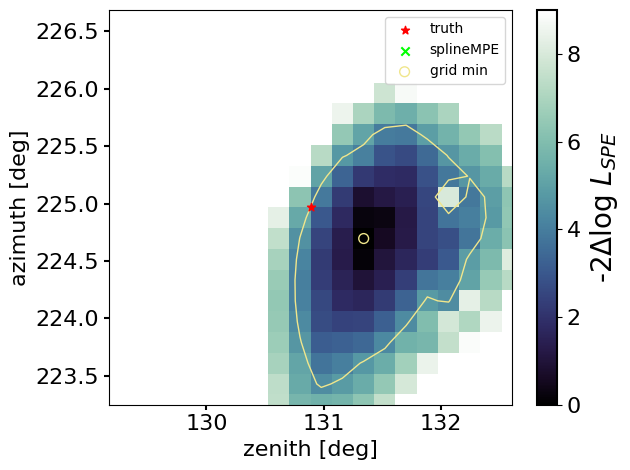

In [21]:
logls = logls.reshape(X.shape)

fig, ax = plt.subplots()
min_logl = np.amin(logls)
delta_logl = logls - np.amin(logls)
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), delta_logl, vmin=0, vmax=np.min([9, 1.2*np.amax(delta_logl)]), shading='auto', cmap=cx)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("-2$\\Delta$log $L_{SPE}$", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-0.03, track_src[0]+0.03]))
ax.set_ylim(np.rad2deg([track_src[1]-0.03, track_src[1]+0.03]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)

smpe_zenith = meta['spline_mpe_zenith']
smpe_azimuth = meta['spline_mpe_azimuth']
ax.scatter(np.rad2deg([smpe_zenith]), np.rad2deg([smpe_azimuth]), marker="x", color='lime', label='splineMPE')

#zenith = result_bfgs.x[0]
#azimuth = result_bfgs.x[1]
#ax.scatter(np.rad2deg(zenith), np.rad2deg(azimuth), marker='^', color='cyan', label='BFGS')

# generate contours
contours = [4.61]
ix1, ix2 = np.where(delta_logl==0)
ax.scatter(np.rad2deg([X[ix1, ix2]]), np.rad2deg([Y[ix1, ix2]]), s=50, marker='o', facecolors='none', edgecolors='khaki', zorder=100., label='grid min')
ct = plt.contour(np.rad2deg(X), np.rad2deg(Y), delta_logl, levels=contours, linestyles=['solid'], colors=['khaki'], linewidths=1.0)

plt.legend()
plt.tight_layout()
plt.show()

In [22]:
print(logls)

[[1385.84329149 1387.78062351 1378.58506425 1383.28923914 1374.24464606
  1368.96304085 1365.70966052 1361.55020738 1359.30972476 1357.594045
  1357.41716606 1357.52727139 1358.21072423 1359.39348513 1360.86813881
  1362.54343641 1364.38474664 1366.24631827 1367.03550397 1367.59218641]
 [1383.02657048 1387.1884644  1376.84059364 1374.86438219 1374.05775747
  1369.43669666 1364.94955192 1361.49691279 1359.27283814 1357.18384797
  1356.30788862 1356.71499956 1357.24085972 1358.34936087 1359.79943227
  1361.48417269 1363.31379467 1363.54407281 1364.98086015 1366.12513369]
 [1390.2533724  1380.88068823 1377.93125304 1375.69908779 1373.9714656
  1369.59124926 1365.07109436 1361.43198214 1358.77091151 1357.02559737
  1355.6162756  1355.922314   1356.60974777 1357.26718179 1358.65658618
  1360.34193677 1361.03644666 1362.86901432 1363.47531664 1368.84207582]
 [1386.75442539 1384.81667044 1377.83899051 1375.18958438 1372.95985879
  1369.66346855 1365.18023364 1361.37622487 1358.52384739 1356.5

In [23]:
with HiddenPrints():
    n_eval = 20
    zenith = jnp.linspace(track_src[0]-0.03, track_src[0]+0.03, n_eval)
    azimuth = jnp.linspace(track_src[1]-0.03, track_src[1]+0.03, n_eval)
    X, Y = jnp.meshgrid(zenith, azimuth)
    init_dirs = jnp.column_stack([X.flatten(), Y.flatten()])
    logls = []
    for tdir in init_dirs:
        logl = solve_3D(centered_track_pos / scale, bounds, tdir, centered_track_time, fitting_event_data)
        logls.append(logl)

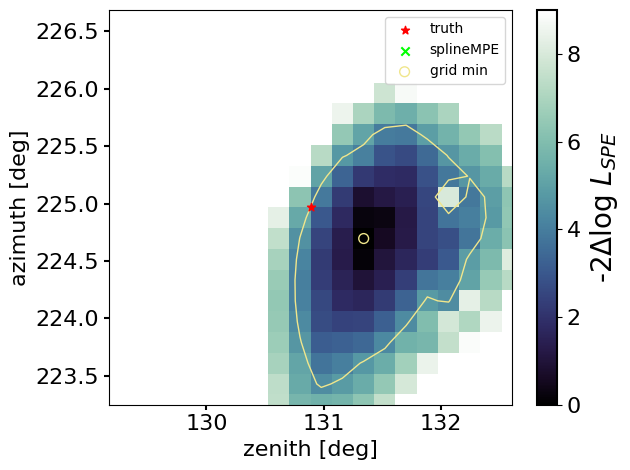

In [24]:
logls = np.array(logls).reshape(X.shape)

fig, ax = plt.subplots()
min_logl = np.amin(logls)
delta_logl = logls - np.amin(logls)
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), delta_logl, vmin=0, vmax=np.min([9, 1.2*np.amax(delta_logl)]), shading='auto', cmap=cx)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("-2$\\Delta$log $L_{SPE}$", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-0.03, track_src[0]+0.03]))
ax.set_ylim(np.rad2deg([track_src[1]-0.03, track_src[1]+0.03]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)

smpe_zenith = meta['spline_mpe_zenith']
smpe_azimuth = meta['spline_mpe_azimuth']
ax.scatter(np.rad2deg([smpe_zenith]), np.rad2deg([smpe_azimuth]), marker="x", color='lime', label='splineMPE')

#zenith = result_bfgs.x[0]
#azimuth = result_bfgs.x[1]
#ax.scatter(np.rad2deg(zenith), np.rad2deg(azimuth), marker='^', color='cyan', label='BFGS')

# generate contours
contours = [4.61]
ix1, ix2 = np.where(delta_logl==0)
ax.scatter(np.rad2deg([X[ix1, ix2]]), np.rad2deg([Y[ix1, ix2]]), s=50, marker='o', facecolors='none', edgecolors='khaki', zorder=100., label='grid min')
ct = plt.contour(np.rad2deg(X), np.rad2deg(Y), delta_logl, levels=contours, linestyles=['solid'], colors=['khaki'], linewidths=1.0)

plt.legend()
plt.tight_layout()
plt.show()